# Overview

This .ipynb notebook demonstrates the complete process of building a deep learning model to classify English news headlines into one of four categories: World, Sports, Business, or Sci/Tech. 

The model is built using a Bidirectional LSTM architecture and enhanced with pre-trained GloVe word embeddings to boost its semantic understanding of text, using the AG News dataset, a widely used benchmark for text classification tasks, and implement the pipeline from raw text to deployment-ready predictions. This includes preprocessing, tokenization, embedding, model training, evaluation, and final visualization.


In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-06-26 12:36:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-26 12:36:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-26 12:36:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
pip install pandas numpy tensorflow scikit-learn matplotlib seaborn datasets nltk tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [5]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.image as mpimg
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-26 12:46:24.474759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750941984.747163      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750941984.829038      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Load the AG News dataset

dataset = load_dataset("ag_news")
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

X_train_raw = train_df['text']
y_train = train_df['label']
X_test_raw = test_df['text']
y_test = test_df['label']

print(f"Training samples: {len(X_train_raw)}")
print(f"Testing samples: {len(X_test_raw)}")
print("Original Training Label Distribution:\n", y_train.value_counts().sort_index())

# Combine train and test for full analysis
full_df = pd.concat([train_df.assign(split="train"), test_df.assign(split="test")])

# Basic structure
print("Shape:", full_df.shape)
print("Columns:", full_df.columns.tolist())
print("Null values:\n", full_df.isnull().sum())
print("Duplicate rows:", full_df.duplicated().sum())

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Training samples: 120000
Testing samples: 7600
Original Training Label Distribution:
 label
0    30000
1    30000
2    30000
3    30000
Name: count, dtype: int64
Shape: (127600, 3)
Columns: ['text', 'label', 'split']
Null values:
 text     0
label    0
split    0
dtype: int64
Duplicate rows: 0


In [7]:
full_df.head()

,text,label,split
0,Wall St. Bears Claw Back Into the Black (Reute...,2,train
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,train
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,train
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,train
4,"Oil prices soar to all-time record, posing new...",2,train


In [8]:
full_df['split'].value_counts()

split
train    120000
test       7600
Name: count, dtype: int64

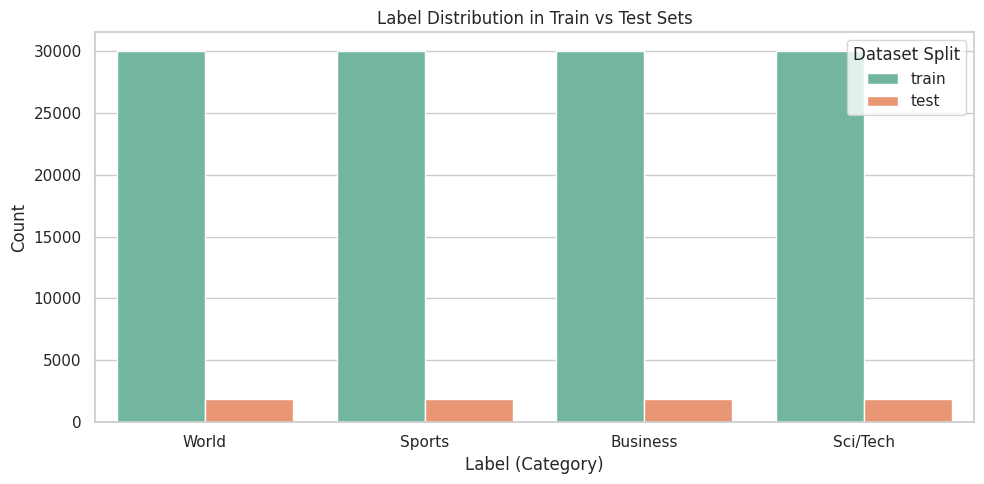

In [9]:
# Label Distribution (Train/Test)

sns.set(style="whitegrid")

# Plot distribution of labels in train and test
plt.figure(figsize=(10, 5))
sns.countplot(data=full_df, x="label", hue="split", palette="Set2")
plt.title("Label Distribution in Train vs Test Sets")
plt.xlabel("Label (Category)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3], labels=["World", "Sports", "Business", "Sci/Tech"])
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

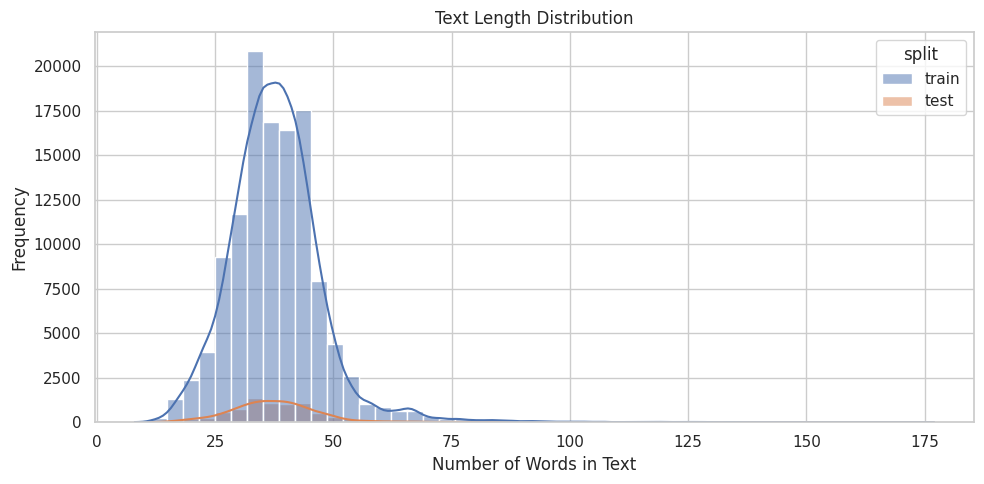

In [10]:
# Add a column with text lengths
full_df["text_length"] = full_df["text"].apply(lambda x: len(x.split()))

# Plot distribution of text lengths
plt.figure(figsize=(10, 5))
sns.histplot(data=full_df, x="text_length", hue="split", bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words in Text")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [12]:
# Text Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]
    return ' '.join(words)

In [13]:
# Apply preprocessing to training and test data
X_train_processed = X_train_raw.progress_apply(preprocess_text) if 'progress_apply' in dir(pd.Series) else X_train_raw.apply(preprocess_text)
X_test_processed = X_test_raw.progress_apply(preprocess_text) if 'progress_apply' in dir(pd.Series) else X_test_raw.apply(preprocess_text)

print("\n-Example Original Text:", X_train_raw.iloc[0][:150], "...\n")
print("-Example Processed Text:", X_train_processed.iloc[0][:150], "...")


-Example Original Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. ...

-Example Processed Text: wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green ...


In [14]:
# Text Preprocessing
MAX_VOCAB_SIZE = 20000 # Max number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 200 # Max length of padded sequences (number of words in an article)
GLOVE_DIM = 100 # Dimension of GloVe vectors
GLOVE_FILE_PATH = "glove.6B.100d.txt"
LSTM_UNITS = 128
DROPOUT_RATE = 0.3
BATCH_SIZE = 64
EPOCHS = 15

# AG News Label Mapping
LABEL_MAP = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}
NUM_CLASSES = len(LABEL_MAP)

print("\n--- Summary ---\n")
print(f"Max Vocabulary Size: {MAX_VOCAB_SIZE}")
print(f"Max Sequence Length: {MAX_SEQUENCE_LENGTH}")
print(f"GloVe Embedding Dimension: {GLOVE_DIM}")
print(f"GloVe File Path: {GLOVE_FILE_PATH}")
print(f"LSTM Units: {LSTM_UNITS}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs (max): {EPOCHS}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Class Names: {LABEL_MAP}")


--- Summary ---

Max Vocabulary Size: 20000
Max Sequence Length: 200
GloVe Embedding Dimension: 100
GloVe File Path: glove.6B.100d.txt
LSTM Units: 128
Dropout Rate: 0.3
Batch Size: 64
Epochs (max): 15
Number of Classes: 4
Class Names: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [15]:
# Convert numerical labels to one-hot encoded
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"\ny_train_encoded shape: {y_train_encoded.shape}\n")
print(f"y_test_encoded shape: {y_test_encoded.shape}")


y_train_encoded shape: (120000, 4)

y_test_encoded shape: (7600, 4)


Unique tokens: 83334
X_train_padded shape: (120000, 200)
X_test_padded shape: (7600, 200)




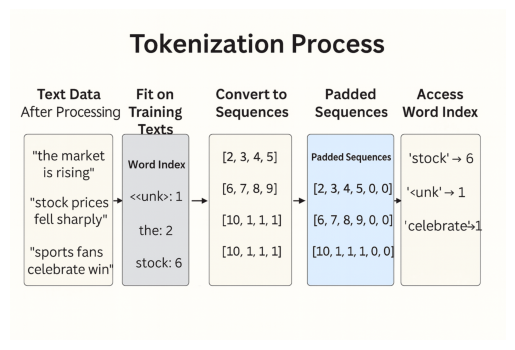

In [16]:
# Tokenizing and Padding Sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(X_train_processed) 

X_train_sequences = tokenizer.texts_to_sequences(X_train_processed)
X_test_sequences = tokenizer.texts_to_sequences(X_test_processed)

X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

word_index = tokenizer.word_index
print(f"Unique tokens: {len(word_index)}")
print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")
print('\n')
img = mpimg.imread('/kaggle/input/token-process/token_process.png')
plt.imshow(img)
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


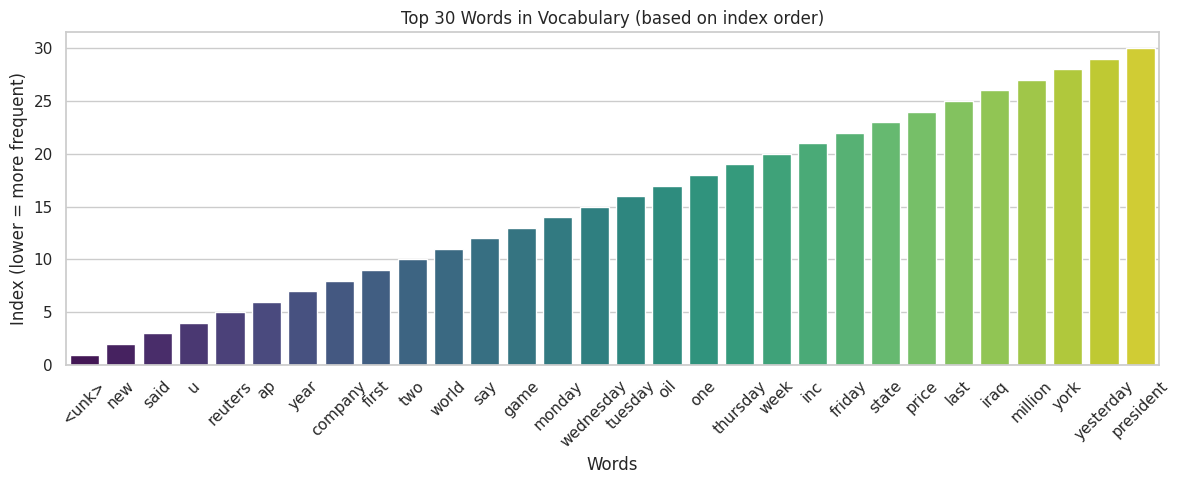

In [21]:
# Most frequent tokens (word index is sorted by frequency)
most_common_words = dict(list(word_index.items())[:30])
words = list(most_common_words.keys())
ranks = list(most_common_words.values())

plt.figure(figsize=(12, 5))
sns.barplot(x=words, y=ranks, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 30 Words in Vocabulary (based on index order)")
plt.ylabel("Index (lower = more frequent)")
plt.xlabel("Words")
plt.tight_layout()
plt.show()

Loaded 400000 word vectors from GloVe.
Embedding matrix Shape: (20000, 100)
Words from my vocabulary found in GloVe embeddings: 18554/20000




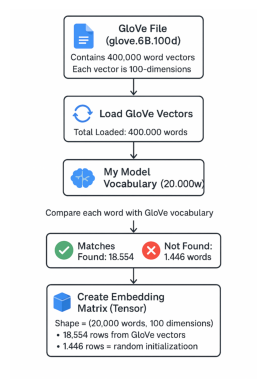

In [17]:
embedding_matrix = None
embedding_index = {}

with open(GLOVE_FILE_PATH, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coeffs = np.asarray(values[1:], dtype='float32')
                embedding_index[word] = coeffs
print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, GLOVE_DIM))
words_found_in_glove = 0

for word, i in word_index.items():
            if i < MAX_VOCAB_SIZE: 
                embedding_vector = embedding_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    words_found_in_glove += 1

print(f"Embedding matrix Shape: {embedding_matrix.shape}")
print(f"Words from my vocabulary found in GloVe embeddings: {words_found_in_glove}/{min(len(word_index), MAX_VOCAB_SIZE)}")
print('\n')
img = mpimg.imread('/kaggle/input/vectors/vectors.png')
plt.imshow(img)
plt.axis('off')
plt.show()

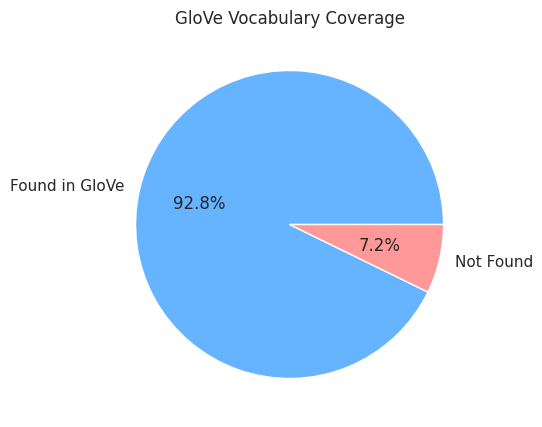

In [23]:
covered = words_found_in_glove
not_covered = MAX_VOCAB_SIZE - covered

plt.figure(figsize=(5, 5))
plt.pie([covered, not_covered], labels=["Found in GloVe", "Not Found"], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title("GloVe Vocabulary Coverage")
plt.show()

In [18]:
# Build Bidirectional LSTM Model

model = Sequential()
model.add(Embedding(input_dim=MAX_VOCAB_SIZE,
                        output_dim=GLOVE_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1750942256.161568      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750942256.162303      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [19]:
# Bidirectional LSTM layer

model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

None


In [6]:
# Model Training

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_agnews_bi_lstm_glove_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    X_train_padded, y_train_encoded,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test_padded, y_test_encoded),
    callbacks=[early_stopping, model_checkpoint]
)

print("\nTraining finished.")


--- 7. Training Model ---
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8456 - loss: 0.4439
Epoch 1: val_accuracy improved from -inf to 0.89395, saving model to best_agnews_bi_lstm_glove_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 807s 425ms/step - accuracy: 0.8456 - loss: 0.4439 - val_accuracy: 0.8939 - val_loss: 0.2971
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8906 - loss: 0.3125
Epoch 2: val_accuracy improved from 0.89395 to 0.90395, saving model to best_agnews_bi_lstm_glove_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 798s 425ms/step - accuracy: 0.8906 - loss: 0.3125 - val_accuracy: 0.9039 - val_loss: 0.2774
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9017 - loss: 0.2834
Epoch 3: val_accuracy improved from 0.90395 to 0.90842, saving model to best_agnews_bi_lstm_glove_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 799s 426ms/step - accuracy: 0.9017 - loss: 0.2834 - val_accuracy: 0.9084 - val_loss: 0.2620
Epoch 4


--- 8. Model Evaluation ---
Loaded best model for final evaluation.

Test Loss: 0.2264
Test Accuracy: 0.9251
238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step

Classification Report:
              precision    recall  f1-score   support

       World       0.96      0.91      0.93      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.89      0.90      0.89      1900
    Sci/Tech       0.89      0.91      0.90      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



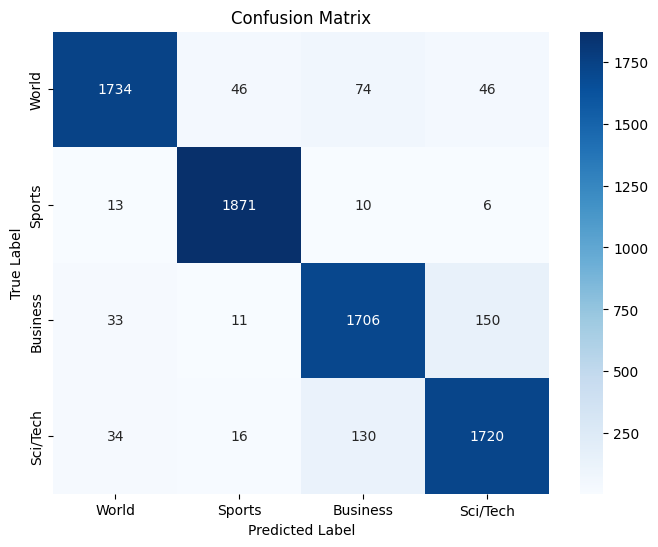

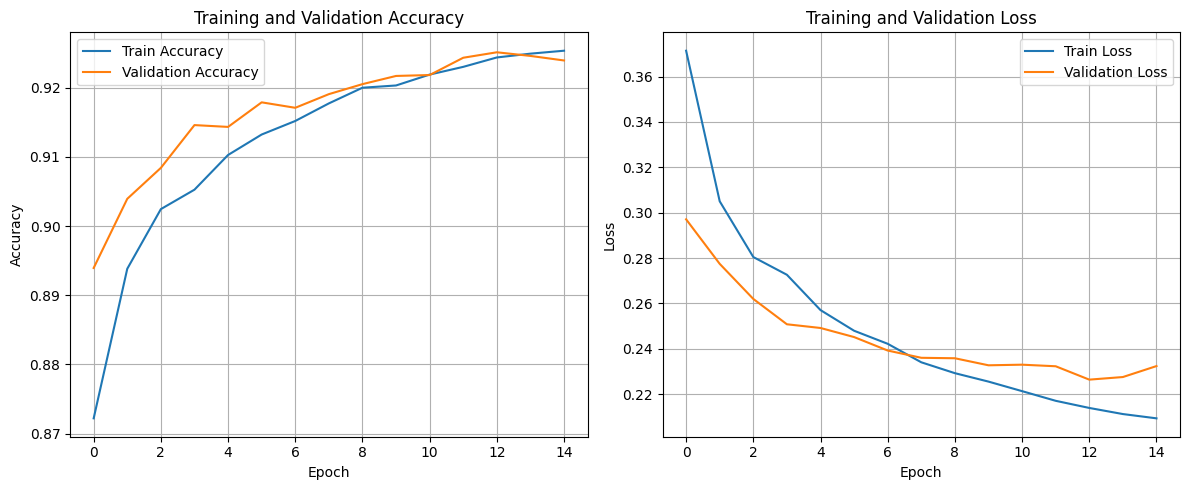

In [7]:
# Model Evaluation

best_model = tf.keras.models.load_model('best_agnews_bi_lstm_glove_model.keras')
loss, accuracy = best_model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions
y_pred_probs = best_model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class indices

# Convert one-hot encoded y_test back to single labels for evaluation metrics
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Classification Report
print("\nClassification Report:")
target_names_list = [LABEL_MAP[i] for i in sorted(LABEL_MAP.keys())]
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names_list))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_list, yticklabels=target_names_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()